# Weekly Work Summary

# Table of Contents

1 Time Series Smoothing <br>
2 Smoothing Techniques <br>
    2.a  Exponential Smoothing <br>
    2.b. Moving Average Smoothing <br>
    2.c. KDE Smoothing <br>
    2.d. Arima for Smoothing <br>

## 1. Time Series Smoothing <a name="smoothing"></a>

In general the goals of time series modeling include, causal inference where the aim could be to describe how a stochastic process evolves, forecasting where the objective is to predict future values, and classification, where we want to classify a subsequence of a time series and more.  Smoothing is a preprocessing technique applied to time series signals to remove or reduce undesired or random variation between time steps so as to improve the performance of a given time series modeling target. The objective of smoothing is to remove noise and better expose the time series signal of the underlying causal processes. Applying smoothing to a time series could result in a signal with clearer patterns (cyclic property, seasonality, property of the residuals) and trends. 

## 2. Smoothing Techniques <a name="techniques"></a>
In this section I would like to experiment time series smoothing techniques using a toy example to illustrate each single step of the smoothing process so as to understand how this approaches work. The data used for experimentation is an hourly average temperature values of Zurich recorded on the 5th of November 2020. The tempreture values are in degree celsius and we assume we have the 24 values in an array. Before I go into each algorithm I would like to specify some of the common symbols that will be used later:
 
| Symbol #  | Representation    
|:-------------|:-----------|
| X  | The whole time series     |
| x  | A single value of the time series   |
| t  | time index for a given value   |
| S  | A smoothed value  |
| $\alpha$  | The smoothing factor   |


In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [8]:
X = [7,7,7,6,6,5,5,6,6,7,8,9,10,10,11,11,12,10,9,8,7,6,6,6]
print("Raw Values")
print("X = ",X)

Raw Values
X =  [7, 7, 7, 6, 6, 5, 5, 6, 6, 7, 8, 9, 10, 10, 11, 11, 12, 10, 9, 8, 7, 6, 6, 6]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from sklearn.neighbors import KernelDensity

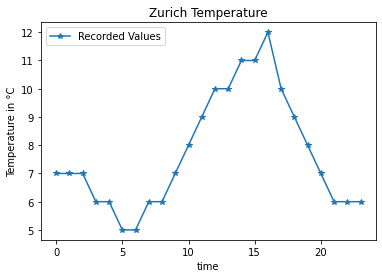

In [9]:
plt.title("Zurich Temperature")
plt.plot(X,"-*")
plt.xlabel("time")
plt.ylabel("Temperature in °C")
plt.legend(['Recorded Values'])
plt.show()

In [10]:
def exponential_smoother(signal,alpha):

    d = signal
    d = np.array(d)  # Transform the input into a numpy array    
    cols = len(d)  # Historical period length    
    #d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods    
    s = np.full(cols,np.nan)  # Forecast array   
    s[0] = d[0]  # initialization of first forecast 
    # Create all the t+1 forecasts until end of historical period

    for t in range(1,cols):      
        s[t] = alpha*d[t-1]+(1-alpha)*s[t-1]   
    
    return s

### 2.a. Exponential Smoothing  <a name="exp"></a>


This technique smoothes a time series signal using weighted averages of past observations, with the weights decaying exponentially as the observations get older. That is, the most recent the observed value is the higher the associated weight. The overall procedure is described below:


<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
    Assume we are given a time series with values in an Array X<br>
    &nbsp;&nbsp;&nbsp;&nbsp; 0. Input:= X ; Output := S // initially empty<br>
    &nbsp;&nbsp;&nbsp;&nbsp; 1. Initialize: $s_{0} = x_{0}$<br>
    &nbsp;&nbsp;&nbsp;&nbsp; 2. for t in 1..length(X)-1:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s_{t} = \alpha *x_{t} + (1 – \alpha) *s_{t-1}$------------(1)<br>    
</div>
The rate at which the weights decrease is controlled by the parameter $\alpha$.
Example:<br>
Applying the above procedure on time series X, we have that s0 = x0 = 7. Then S1 is computed by plugging in s0=7, x1=7 and $\alpha$= 0.8 in equation 1 we get, <br>
$s1 = (0.8 *7) + (1-0.8)*7 = 5.6 + 1.4 = 7$. The table and plot below show the input data and the smoothed data after applying exponential smoothing. 

    Input  Exp_Smoothing
0       7       7.000000
1       7       7.000000
2       7       7.000000
3       6       7.000000
4       6       6.200000
5       5       6.040000
6       5       5.208000
7       6       5.041600
8       6       5.808320
9       7       5.961664
10      8       6.792333
11      9       7.758467
12     10       8.751693
13     10       9.750339
14     11       9.950068
15     11      10.790014
16     12      10.958003
17     10      11.791601
18      9      10.358320
19      8       9.271664
20      7       8.254333
21      6       7.250867
22      6       6.250173
23      6       6.050035


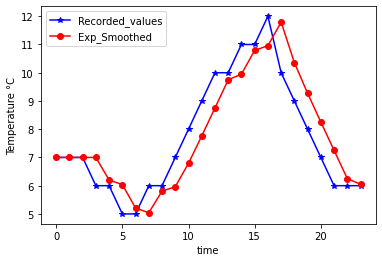

In [17]:
df = pd.DataFrame(X,columns=['Input'])
df['Exp_Smoothing']=exponential_smoother(X,0.8)
print(df)
plt.plot(X,'-*b')
plt.plot(df.Exp_Smoothing,'-or')
plt.xlabel('time')
plt.ylabel('Temperature °C')
plt.legend(['Recorded_values','Exp_Smoothed'])
plt.show()

In [18]:
def moving_avg_smoother(signal,window):
    a = signal
    n = window
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    s = ret[n - 1:] / n
    return s

### 2.b. Moving Average <a name="mvavg"></a>
Smoothing by taking the average in a given window is the simplest technique of removing random variation of a time series signal. The procedure of a moving average smoothing is as follows:
<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
    Assume we are given a time series with values in an Array X<br>
    &nbsp;&nbsp;&nbsp;&nbsp; 0. Input:= X ; Output := $MA_{w}$ // initially empty<br>
    &nbsp;&nbsp;&nbsp;&nbsp; 1. Initialize: $step = 1 ; w = 3$<br>
    &nbsp;&nbsp;&nbsp;&nbsp; 2. for t in 1..length(X)-2:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s_{t} = (1/w)*\sum_{i=t-1}^{t+1} x_{i}$------------(2)<br>    
</div>


    Input  Exp_Smoothing         MA  KDE
0       7       7.000000   7.000000    6
1       7       7.000000   7.000000    6
2       7       7.000000   6.666667    6
3       6       7.000000   6.333333    6
4       6       6.200000   5.666667    5
5       5       6.040000   5.333333    5
6       5       5.208000   5.333333    5
7       6       5.041600   5.666667    5
8       6       5.808320   6.333333    6
9       7       5.961664   7.000000    7
10      8       6.792333   8.000000    8
11      9       7.758467   9.000000    8
12     10       8.751693   9.666667    9
13     10       9.750339  10.333333   10
14     11       9.950068  10.666667   10
15     11      10.790014  11.333333   11
16     12      10.958003  11.000000   11
17     10      11.791601  10.333333   10
18      9      10.358320   9.000000    9
19      8       9.271664   8.000000    8
20      7       8.254333   7.000000    7
21      6       7.250867   6.333333    6
22      6       6.250173   6.000000    6
23      6       

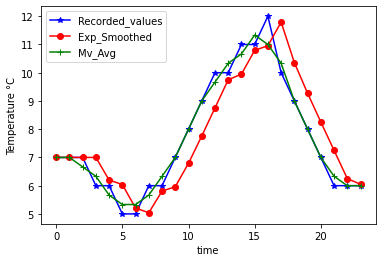

In [79]:
MA = list(moving_avg_smoother(X,3))
MA.insert(0,X[0])
MA.insert(len(MA),X[-1])
df['MA']=MA
print(df)
plt.plot(X,'-*b')
plt.plot(df.Exp_Smoothing,'-or')
plt.plot(df.MA,'-+g')
plt.xlabel('time')
plt.ylabel('Temperature °C')
plt.legend(['Recorded_values','Exp_Smoothed','Mv_Avg'])
plt.show()

### 2.c. KDE Smoothing <a name="kde"></a>
This is a method where probability distribution of observations is used as weights for averaging so as to get a smooth signal. The probabilities are then used as smoothing factors for past and future values to compute the current smoothed value. The kde smoothing procedure is as follows:
<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
    Assume we are given a time series with values in an Array X<br>
    &nbsp;&nbsp;&nbsp;&nbsp; 0. Input:= X ; Output := x_kde // initially empty<br>
    &nbsp;&nbsp;&nbsp;&nbsp; 1. Initialize: h = the bandwidth, sigma = std(X)<br>
    &nbsp;&nbsp;&nbsp;&nbsp; 2. for t in 0..length(X)-1://outer loop<br>
    &nbsp;&nbsp;&nbsp;&nbsp; 3. $s_{t} = 0$<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3. for t' in 0..length(X)-1://inner loop<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$d(x_{t},x_{t'}) = SQRT((x_{t}- x_{t'})^2)$ <br>  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$ a = 1/(sigma^2*2*\pi)$ //normalizing factor <br> 
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$ p = a*\exp(-d/2*sigma^2)$ //smoothing factor or probability <br> 
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$ s_{t} = s_{t} + p*x_{t'}$ //smoothed value <br> 
     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4. append(S,$s_{t}$)<br>
</div>



In [93]:
def kde_smoother(signal):
    def kernel_fn(x,x0):
        d = np.sqrt((x-x0)**2)
        sigma = np.std(x)**2
        a = 1/(sigma*3.14*2)
        p = a* np.exp(-0.5*(d)/(sigma))
        s = np.multiply(p,x)
        s = np.sum(s)
        return s
    fh = [kernel_fn(signal,x) for x in signal]
    return fh

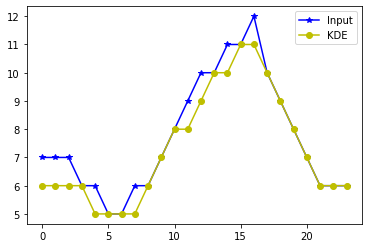

In [98]:
from scipy.ndimage.filters import gaussian_filter1d
x_kde = gaussian_filter1d(X, 1)
df['KDE']=x_kde
plt.plot(df['Input'],'-*b')
plt.plot(df['KDE'],'-oy')
plt.legend(['Input','KDE'])
plt.show()

In [99]:
df

,Input,Exp_Smoothing,MA,KDE
0,7,7.000000,7.000000,6
1,7,7.000000,7.000000,6
2,7,7.000000,6.666667,6
3,6,7.000000,6.333333,6
4,6,6.200000,5.666667,5
5,5,6.040000,5.333333,5
6,5,5.208000,5.333333,5
7,6,5.041600,5.666667,5
8,6,5.808320,6.333333,6
9,7,5.961664,7.000000,7


In [102]:
from sklearn.metrics import mean_squared_error as mse
print('RMSE Exp_Smoothing = ',np.sqrt(mse(df['Input'].values,df['Exp_Smoothing'].values)))
print('RMSE MovingAvg_Smoothing = ',np.sqrt(mse(df['Input'].values,df['MA'].values)))
print('RMSE KDE_Smoothing = ',np.sqrt(mse(df['Input'].values,df['KDE'].values)))

RMSE Exp_Smoothing =  0.9337660546291883
RMSE MovingAvg_Smoothing =  0.31914236925211276
RMSE KDE_Smoothing =  0.6123724356957945
